In [1]:
import numpy as np
import os
from skimage.io import imread, imsave
from skimage.transform import rescale, resize
import matplotlib.pyplot as plt

from api import PRN
from utils.render import render_texture
import cv2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
prn = PRN(is_opencv = True) 

INFO:tensorflow:Restoring parameters from ./Data/net-data/256_256_resfcn256_weight


# 第一张图

In [3]:
# read image
img = imread('./images/zly3.jpg')
[h, w, _] = img.shape
# 3d reconstruction -> get texture. 

pos = prn.process(img) 
vertices = prn.get_vertices(pos)
img = img/255.
texture = cv2.remap(img, pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))


## 第二张图

In [4]:
ref_img = imread('./images/hjh.jpg')
ref_pos = prn.process(ref_img)
ref_img = ref_img/255.
ref_texture = cv2.remap(ref_img, ref_pos[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_NEAREST, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
ref_vertices = prn.get_vertices(ref_pos)


# 融合texture
替换人脸mask

In [5]:
def blendImages(src, dst, mask, featherAmount=0.2):
    #indeksy nie czarnych pikseli maski
    maskIndices = np.where(mask != 0)
    #te same indeksy tylko, ze teraz w jednej macierzy, gdzie kazdy wiersz to jeden piksel (x, y)
    maskPts = np.hstack((maskIndices[1][:, np.newaxis], maskIndices[0][:, np.newaxis]))
    faceSize = np.max(maskPts, axis=0) - np.min(maskPts, axis=0)
    featherAmount = featherAmount * np.max(faceSize)

    hull = cv2.convexHull(maskPts)
    dists = np.zeros(maskPts.shape[0])
    for i in range(maskPts.shape[0]):
        dists[i] = cv2.pointPolygonTest(hull, (maskPts[i, 0], maskPts[i, 1]), True)

    weights = np.clip(dists / featherAmount, 0, 1)

    composedImg = np.copy(dst)
    composedImg[maskIndices[0], maskIndices[1]] = weights[:, np.newaxis] * src[maskIndices[0], maskIndices[1]] + (1 - weights[:, np.newaxis]) * dst[maskIndices[0], maskIndices[1]]

    return composedImg
def colorTransfer(src, dst, mask):
    transferredDst = np.copy(dst)
    #indeksy nie czarnych pikseli maski
    maskIndices = np.where(mask != 0)
    #src[maskIndices[0], maskIndices[1]] zwraca piksele w nie czarnym obszarze maski

    maskedSrc = src[maskIndices[0], maskIndices[1]].astype(np.int32)
    maskedDst = dst[maskIndices[0], maskIndices[1]].astype(np.int32)

    meanSrc = np.mean(maskedSrc, axis=0)
    meanDst = np.mean(maskedDst, axis=0)

    maskedDst = maskedDst - meanDst
    maskedDst = maskedDst + meanSrc
    maskedDst = np.clip(maskedDst, 0, 255)

    transferredDst[maskIndices[0], maskIndices[1]] = maskedDst

    return transferredDst

In [6]:
# load eye mask
uv_face_eye = imread('Data/uv-data/uv_noface1.png', as_gray=True)/255. 
uv_face = imread('Data/uv-data/uv_face.png', as_gray=True)/255.
eye_mask = (abs(uv_face_eye - uv_face) > 0).astype(np.float32)

# modify texture
# new_texture = texture*(1 - eye_mask[:,:,np.newaxis]) + ref_texture*eye_mask[:,:,np.newaxis]
new_texture = blendImages(ref_texture*255,texture*255,eye_mask)/255.0

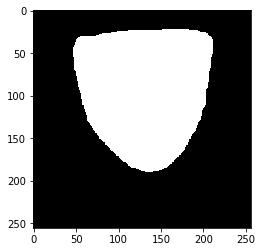

In [7]:
plt.imshow(eye_mask,cmap='gray')

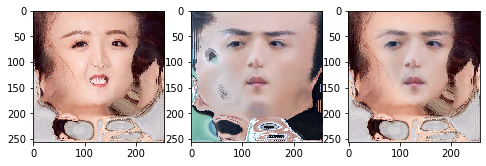

In [8]:
plt.figure(figsize=(8,8))
plt.subplot(131)
plt.imshow(texture)
plt.subplot(132)
plt.imshow(ref_texture)
plt.subplot(133)
plt.imshow(new_texture)

In [9]:
vis_colors = np.ones((vertices.shape[0], 1))
face_mask = render_texture(vertices.T, vis_colors.T, prn.triangles.T, h, w, c = 1)
face_mask = np.squeeze(face_mask > 0).astype(np.float32)

new_colors = prn.get_colors_from_texture(new_texture)
new_img = render_texture(vertices.T, new_colors.T, prn.triangles.T, h, w, c = 3)
new_image = img*(1 - face_mask[:,:,np.newaxis]) + new_img*face_mask[:,:,np.newaxis]


(-0.5, 3343.5, 2041.5, -0.5)

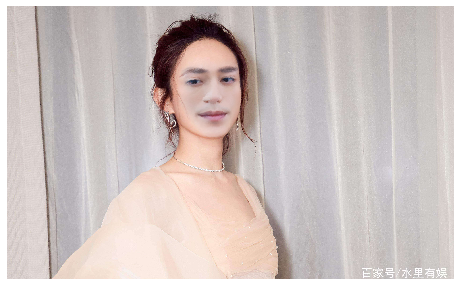

In [10]:
plt.figure(figsize=(8,8))
plt.imshow(new_image)
plt.imsave('./images/results/result.jpg',new_image)
plt.axis('off')

## 提取人脸关键点

In [11]:
def draw_kps(img,kps,point_size=2):
    img = np.array(img*255,np.uint8)
    for i in range(kps.shape[0]):
        cv2.circle(img,(int(kps[i,0]),int(kps[i,1])),point_size,(0,255,0),-1)
    return img

(-0.5, 3343.5, 2041.5, -0.5)

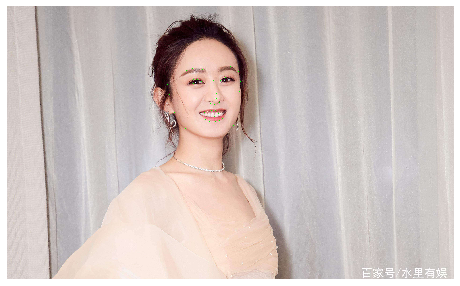

In [12]:
face_kps = prn.get_landmarks(pos)
plt.figure(figsize=(8,8))
plt.imshow(draw_kps(img.copy(),face_kps[...,0:2],3))
plt.axis('off')